# Tutorial-1: Linear spin wave for triangular lattice XXZ model with spin-1/2

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from joblib import Parallel, delayed
import spintoolkit_py as sptk

## Define a triangular lattice to be used

In [2]:
sptk.print_system_info()
latt = sptk.lattice(filename = "triangular_K.toml")

Hostname:                d196575d6e36
CPU Type:                12th Gen Intel(R) Core(TM) i9-12900
Thread count:            16
Platform:                linux
Time Now:                2026-02-04---06:57:58.35---UTC

OMP version:             202011
OMP bind policy:         false
OMP number of procs:     16
OMP number of threads:   4
OMP number of devices:   0

Boost lib version:       1_83
NLopt version:           2.7.1
SPGlib version:          2.3.1
SpinToolkit Compiled by: Clang version 18.1.3 (1ubuntu1) (-O1, -O2, -O3) on Feb  3 2026
SpinToolkit version:     1.6.0

Reading lattice information from triangular_K.toml
L       = 3
num_sub = 1
dim     = 2
Real space basis (a):                              
a0: [                   1                   0]
a1: [                -0.5           0.8660254]
Reciprocal space basis (b / 2π):                   
b0: [                   1           0.5773503]
b1: [                   0            1.154701]
Superlattice real space basis (A) [unit: a]:    

## Define the model and include magnetic couplings

In [3]:
J = 1.0    # nearest-neighbor exchange
Δ = 1.2    # exchange anisotropy
h = 0.05   # zeeman coupling

hamiltonian = sptk.model_spin(S = 0.5, mode = "dipole", lattice = latt)
print()

L = latt.total_sites()
for site_i in range(L):
    coor_i, sub_i = latt.site2coor(site = site_i)
    coor0_i, r̃i   = latt.r2superlattice(coor = coor_i)
    xi = coor_i[0]
    yi = coor_i[1]

    coor_j      = [xi + 1, yi]
    coor0_j, r̃j = latt.r2superlattice(coor = coor_j)
    site_j      = latt.coor2site(coor = coor_j, sub = 0)
    hamiltonian.add_2spin_XYZ(J = sptk.Vec3(J, J, Δ * J),
                              site_i = site_i, site_j = site_j,
                              rtilde_i = r̃i, rtilde_j = r̃j)

    coor_j      = [xi, yi + 1]
    coor0_j, r̃j = latt.r2superlattice(coor = coor_j)
    site_j      = latt.coor2site(coor = coor_j, sub = 0)
    hamiltonian.add_2spin_XYZ(J = sptk.Vec3(J, J, Δ * J),
                              site_i = site_i, site_j = site_j,
                              rtilde_i = r̃i, rtilde_j = r̃j)

    coor_j      = [xi + 1, yi + 1]
    coor0_j, r̃j = latt.r2superlattice(coor = coor_j)
    site_j      = latt.coor2site(coor = coor_j, sub = 0)
    hamiltonian.add_2spin_XYZ(J = sptk.Vec3(J, J, Δ * J),
                              site_i = site_i, site_j = site_j,
                              rtilde_i = r̃i, rtilde_j = r̃j)

    hamiltonian.add_zeeman(h = sptk.Vec3(0.0, 0.0, h), site = site_i)

hamiltonian.simplify().build_mc_list()
print()

Model with S=1/2 (mode = dipole) initialized.

simplifying bond_Jij:                  9     ----->          9,	 elapsed time: 0.000191688s.
simplifying site_zeeman:               3     ----->          3,	 elapsed time: 0.000187945s.
building interaction list for MC... 6.072e-06s.
Average coordination (bilinear) per site:     2
Average coordination (biquadratic) per site:  0
Number of onsite anisotropy:                  0
Number of CEF terms:                          0
Number of Zeeman terms:                       3
E_shift/L:                                    0



## Perform minimization (minimize from several independent initial random guesses, then pick the lowest-energy solution)

In [4]:
print("Optimizing ground state", end = "... ", flush = True)
start        = time.perf_counter()
s_min, e_min = hamiltonian.optimize_spins_dipole(total_seeds = 30) # more seeds -> more likely to hit global minimum
end          = time.perf_counter()
print(f"{end - start}s")
print()

print(f"e_min (global): {e_min}")
for i in range(L):
    print(f"site-{i}: {s_min[i]}")

Optimizing ground state... 0.015903774999969755s

e_min (global): -0.41452020202020207
site-0: <sptk.Vec3>: [0.810987, 0.167395, 0.560606]
site-1: <sptk.Vec3>: [-0.810987, -0.167395, 0.560606]
site-2: <sptk.Vec3>: [9.42822e-09, 1.84612e-09, -1]


## Initialize the LSW calculation and prepare the rotation matrices $\vec{S}_i = R_i (S\hat{z})$

In [5]:
R = hamiltonian.init_LSW(s_min = s_min)
for i in range(L):
    print(f"site-{i}:")
    print(R[i])
    print()

site-0:
<sptk.Mat3_rotation>:
[                 0.549032                -0.202148                 0.810987]
[                 0.113325                 0.979355                 0.167395]
[                -0.828083                        0                 0.560606]

site-1:
<sptk.Mat3_rotation>:
[                -0.549032                 0.202148                -0.810987]
[                -0.113325                -0.979355                -0.167395]
[                -0.828083                        0                 0.560606]

site-2:
<sptk.Mat3_rotation>:
[                -0.981364                -0.192159                        0]
[                -0.192159                 0.981364                        0]
[                        0                        0                       -1]



## Define a k-space trajectory and a list of $\omega$ for computing $\mathcal{S}^{\mu\nu}(\boldsymbol{k}, \omega)$

In [6]:
kc = sptk.k_cut(lattice = latt, density = 50)
kc.add_k(k_new = [0.0, 0.0])               # Gamma
kc.add_k(k_new = [0.5, 0.0])               # M
xtic_M = kc.len_list[-1]                   # x-axis position for M-point (for plotting)
kc.add_k(k_new = [1.0 / 3.0, 1.0 / 3.0])   # K
xtic_K = kc.len_list[-1]                   # x-axis position for K-point (for plotting)
kc.add_k(k_new = [0.0, 0.0])               # Gamma
total_k = kc.size()

ω_max = 7.0
num_ω = 350
ω_list = np.arange(0, ω_max, ω_max / num_ω, dtype = np.float64).tolist()

## Compute 1-magnon DSSF $\mathcal{S}_1^{\mu\nu}(\boldsymbol{k},\omega)$

In [7]:
omega_k  = []
Sxx      = []
Syy      = []
Szz      = []
SxyPyx_R = []
SyzPzy_R = []
SzxPxz_R = []
SxyMyx_I = []
SyzMzy_I = []
SzxMxz_I = []

start = time.perf_counter()
for index_k in range(total_k):
    k = kc.k_list[index_k]
    if index_k % sptk.round2int(total_k / 50.0 + 1.0) == 0:
        print("*", end = "", flush = True)
    try:
        disp0, Sxx0, Syy0, Szz0, \
        SxyPyx_R0, SyzPzy_R0, SzxPxz_R0, \
        SxyMyx_I0, SyzMzy_I0, SzxMxz_I0 \
        = sptk.DSSF_LSW(model = hamiltonian, R = R, T = 0.0,
                        k = k, omega_list = ω_list,
                        eval_1magnon = True, maxeval_2magnon = 0,
                        maxeval_3magnon = 0, maxeval_0magnon = 0,
                        broadening = "Gaussian", sigma_or_eta = 0.05 / 2.35482,
                        epsilon = 1.0e-4)
        omega_k.append(disp0)
        Sxx.append(Sxx0)
        Syy.append(Syy0)
        Szz.append(Szz0)
        SxyPyx_R.append(SxyPyx_R0)
        SyzPzy_R.append(SyzPzy_R0)
        SzxPxz_R.append(SzxPxz_R0)
        SxyMyx_I.append(SxyMyx_I0)
        SyzMzy_I.append(SyzMzy_I0)
        SzxMxz_I.append(SzxMxz_I0)
    except Exception as e:
        print(f"error: {e}, k = {k}")
print()
end = time.perf_counter()
print(f"Used {end - start:.6f}s")

**************************************
Used 0.026207s


## Plot 1-magnon DSSF $\mathcal{S}_1(\boldsymbol{k}, \omega) \equiv \mathcal{S}_1^{xx}(\boldsymbol{k}, \omega) + \mathcal{S}_1^{yy}(\boldsymbol{k}, \omega) + \mathcal{S}_1^{zz}(\boldsymbol{k}, \omega)$

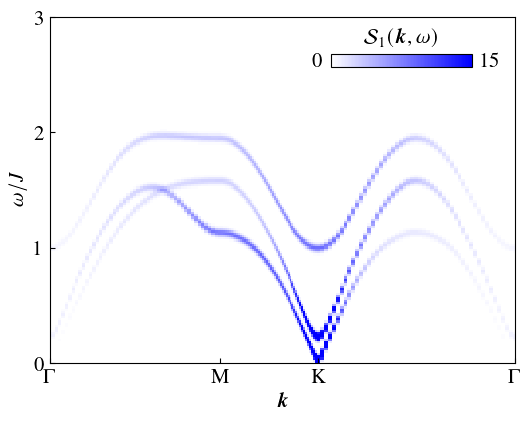

In [8]:
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['font.size'] = 15

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,newtxtext,newtxmath,bm}'
plt.rcParams['font.family'] = 'TeX Gyre Termes'

x = kc.len_list
axis_X, axis_Y = np.meshgrid(x, ω_list)
Intensity = (np.array(Sxx) + np.array(Syy) + np.array(Szz)).transpose()

fig, ax = plt.subplots()

cmap = colors.LinearSegmentedColormap.from_list("white_to_blue", [(1, 1, 1), (0, 0, 1)], N = 100)
imag = ax.pcolormesh(axis_X, axis_Y, Intensity, cmap = cmap, shading = "auto", vmin = 0, vmax = 15)

ax.set_xlim(x[0], x[-1])
ax.set_ylim(0.0, 3.0)
ax.set_xticks([x[0], xtic_M, xtic_K, x[-1]], [r"$\Gamma$", "M", "K", r"$\Gamma$"])
ax.set_yticks([0, 1, 2, 3])
ax.set_xlabel(r"$\bm{k}$")
ax.set_ylabel(r"$\omega/J$")
ax.tick_params(direction = 'in', color = 'black')

ax.text(6.7, 2.77, r'$\mathcal{S}_1(\bm{k},\omega)$', fontsize = 15)
ax.text(5.6, 2.57, r'$0$', fontsize = 15)
ax.text(9.2, 2.57, r'$15$', fontsize = 15)

cax  = ax.inset_axes((6.0, 2.56, 3.0, 0.12), transform = ax.transData)
cbar = fig.colorbar(imag, cax = cax, orientation = "horizontal")
cbar.set_ticks([0, 15])
cbar.set_ticklabels(['', ''])
cbar.ax.tick_params(length = 0)

plt.show()

## Compute 2-magnon DOS $\mathcal{D}_2(\boldsymbol{k},\omega)$ (should only be used with a primitive super-lattice basis)

In [9]:
dos       = []
omega_min = []
omega_max = []

start = time.perf_counter()
for index_k in range(total_k):
    k = kc.k_list[index_k]
    if index_k % sptk.round2int(total_k / 50.0 + 1.0) == 0:
        print("*", end = "", flush = True)
    try:
        dos0, omega_min0, omega_max0 \
        = sptk.DOS_LSW(model = hamiltonian, R = R,
                       k = k, omega_list = ω_list,
                       maxeval_2magnon = 50000, maxeval_3magnon = 0,
                       broadening = "Gaussian", sigma_or_eta = 0.05 / 2.35482,
                       epsilon = 1.0e-4)
        dos.append(dos0)
        omega_min.append(omega_min0)
        omega_max.append(omega_max0)
    except Exception as e:
        print(f"error: {e}, k = {k}")
print()
end = time.perf_counter()
print(f"Used {end - start:.6f}s")

**************************************
Used 211.869245s


## Plot 2-magnon DOS $\mathcal{D}_2(\boldsymbol{k}, \omega)$

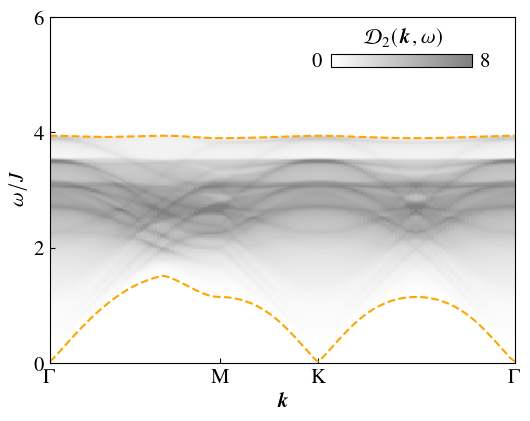

In [10]:
x = kc.len_list
axis_X, axis_Y = np.meshgrid(x, ω_list)

fig, ax = plt.subplots()

cmap = colors.LinearSegmentedColormap.from_list("white_to_gray", [(1, 1, 1), (0.5, 0.5, 0.5)], N = 100)
imag = ax.pcolormesh(axis_X, axis_Y, np.array(dos).transpose(), cmap = cmap, shading = "auto", vmin = 0, vmax = 8)
ax.plot(x, np.array(omega_min), '--', color = 'orange')
ax.plot(x, np.array(omega_max), '--', color = 'orange')

ax.set_xlim(x[0], x[-1])
ax.set_ylim(0.0, 6.0)
ax.set_xticks([x[0], xtic_M, xtic_K, x[-1]], [r"$\Gamma$", "M", "K", r"$\Gamma$"])
ax.set_yticks([0, 2, 4, 6])
ax.set_xlabel(r"$\bm{k}$")
ax.set_ylabel(r"$\omega/J$")
ax.tick_params(direction = 'in', color = 'black')

ax.text(6.7, 5.54, r'$\mathcal{D}_2(\bm{k},\omega)$', fontsize = 15)
ax.text(5.6, 5.14, r'$0$', fontsize = 15)
ax.text(9.2, 5.14, r'$8$', fontsize = 15)

cax  = ax.inset_axes((6.0, 5.12, 3.0, 0.24), transform = ax.transData)
cbar = fig.colorbar(imag, cax = cax, orientation = "horizontal")
cbar.set_ticks([0, 8])
cbar.set_ticklabels(['', ''])
cbar.ax.tick_params(length = 0)

plt.show()

## Compute 2-magnon DSSF $\mathcal{S}_2^{\mu\nu}(\boldsymbol{k},\omega)$

In [11]:
omega_k  = []
Sxx      = []
Syy      = []
Szz      = []
SxyPyx_R = []
SyzPzy_R = []
SzxPxz_R = []
SxyMyx_I = []
SyzMzy_I = []
SzxMxz_I = []

start = time.perf_counter()
for index_k in range(total_k):
    k = kc.k_list[index_k]
    if index_k % sptk.round2int(total_k / 50.0 + 1.0) == 0:
        print("*", end = "", flush = True)
    try:
        disp0, Sxx0, Syy0, Szz0, \
        SxyPyx_R0, SyzPzy_R0, SzxPxz_R0, \
        SxyMyx_I0, SyzMzy_I0, SzxMxz_I0 \
        = sptk.DSSF_LSW(model = hamiltonian, R = R, T = 0.0,
                        k = k, omega_list = ω_list,
                        eval_1magnon = False, maxeval_2magnon = 50000,
                        maxeval_3magnon = 0, maxeval_0magnon = 0,
                        broadening = "Gaussian", sigma_or_eta = 0.05 / 2.35482,
                        epsilon = 1.0e-4)
        omega_k.append(disp0)
        Sxx.append(Sxx0)
        Syy.append(Syy0)
        Szz.append(Szz0)
        SxyPyx_R.append(SxyPyx_R0)
        SyzPzy_R.append(SyzPzy_R0)
        SzxPxz_R.append(SzxPxz_R0)
        SxyMyx_I.append(SxyMyx_I0)
        SyzMzy_I.append(SyzMzy_I0)
        SzxMxz_I.append(SzxMxz_I0)
    except Exception as e:
        print(f"error: {e}, k = {k}")
print()
end = time.perf_counter()
print(f"Used {end - start:.6f}s")

**************************************
Used 284.927594s


## Plot 2-magnon DSSF $\mathcal{S}_2(\boldsymbol{k}, \omega) \equiv \mathcal{S}_2^{xx}(\boldsymbol{k}, \omega) + \mathcal{S}_2^{yy}(\boldsymbol{k}, \omega) + \mathcal{S}_2^{zz}(\boldsymbol{k}, \omega)$

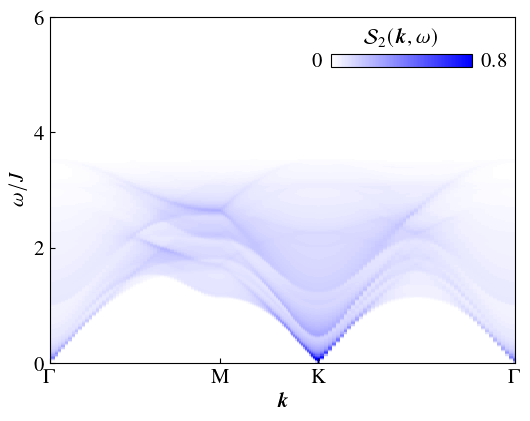

In [12]:
x = kc.len_list
axis_X, axis_Y = np.meshgrid(x, ω_list)
Intensity = (np.array(Sxx) + np.array(Syy) + np.array(Szz)).transpose()

fig, ax = plt.subplots()

cmap = colors.LinearSegmentedColormap.from_list("white_to_blue", [(1, 1, 1), (0, 0, 1)], N = 100)
imag = ax.pcolormesh(axis_X, axis_Y, Intensity, cmap = cmap, shading = "auto", vmin = 0, vmax = 0.8)
# uncomment the following line if you like to overplot the 1-magnon dispersion
# ax.plot(x, np.array(omega_k), 'r--')

ax.set_xlim(x[0], x[-1])
ax.set_ylim(0.0, 6.0)
ax.set_xticks([x[0], xtic_M, xtic_K, x[-1]], [r"$\Gamma$", "M", "K", r"$\Gamma$"])
ax.set_yticks([0, 2, 4, 6])
ax.set_xlabel(r"$\bm{k}$")
ax.set_ylabel(r"$\omega/J$")
ax.tick_params(direction = 'in', color = 'black')

ax.text(6.7, 5.54, r'$\mathcal{S}_2(\bm{k},\omega)$', fontsize = 15)
ax.text(5.6, 5.14, r'$0$', fontsize = 15)
ax.text(9.2, 5.14, r'$0.8$', fontsize = 15)

cax  = ax.inset_axes((6.0, 5.12, 3.0, 0.24), transform = ax.transData)
cbar = fig.colorbar(imag, cax = cax, orientation = "horizontal")
cbar.set_ticks([0, 0.8])
cbar.set_ticklabels(['', ''])
cbar.ax.tick_params(length = 0)

plt.show()

## Compute 3-magnon DOS $\mathcal{D}_3(\boldsymbol{k},\omega)$ (should only be used with a primitive super-lattice basis)
Since the 3-magnon calculation is quite demanding to achieve high accuracy, in the following we will run it in parallel (the 2-magnon part can be modified in the same way).

In this example, we fix the number of threads via the environment variable OMP_NUM_THREADS, which you can set before starting the jupyter notebook, e.g.,
```
export OMP_NUM_THREADS=4
```

**Warning**: Do not set OMP_NUM_THREADS to be more than your number of CPU cores!!!

In [13]:
def process_D3(index_k):
    k = kc.k_list[index_k]
    if index_k % sptk.round2int(total_k / 50.0 + 1.0) == 0:
        print("*", end = "", flush = True)
    try:
        return sptk.DOS_LSW(model = hamiltonian, R = R,
                            k = k, omega_list = ω_list,
                            maxeval_2magnon = 0, maxeval_3magnon = 200000,
                            broadening = "Gaussian", sigma_or_eta = 0.05 / 2.35482,
                            epsilon = 1.0e-4)
    except Exception as e:
        print(f"error: {e}, k = {k}")

start = time.perf_counter()
results_D3 = Parallel(n_jobs = sptk.total_omp_threads(), prefer = "threads")(
    delayed(process_D3)(index_k) for index_k in range(total_k))
dos, omega_min, omega_max = zip(*results_D3)
print()
end = time.perf_counter()
print(f"Used {end - start:.6f}s")

**************************************
Used 604.668290s


## Plot 3-magnon DOS $\mathcal{D}_3(\boldsymbol{k}, \omega)$

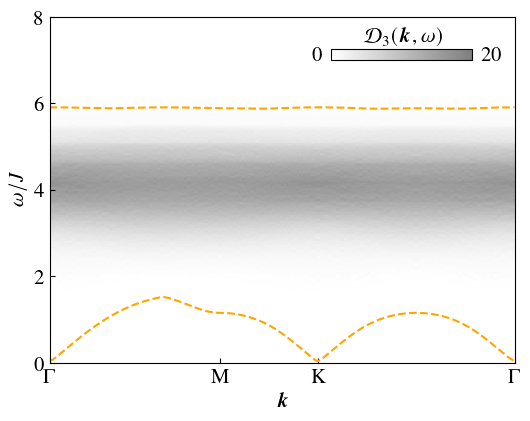

In [14]:
x = kc.len_list
axis_X, axis_Y = np.meshgrid(x, ω_list)

fig, ax = plt.subplots()

cmap = colors.LinearSegmentedColormap.from_list("white_to_gray", [(1, 1, 1), (0.5, 0.5, 0.5)], N = 100)
imag = ax.pcolormesh(axis_X, axis_Y, np.array(dos).transpose(), cmap = cmap, shading = "auto", vmin = 0, vmax = 20)
ax.plot(x, np.array(omega_min), '--', color = 'orange')
ax.plot(x, np.array(omega_max), '--', color = 'orange')

ax.set_xlim(x[0], x[-1])
ax.set_ylim(0.0, 8.0)
ax.set_xticks([x[0], xtic_M, xtic_K, x[-1]], [r"$\Gamma$", "M", "K", r"$\Gamma$"])
ax.set_yticks([0, 2, 4, 6, 8])
ax.set_xlabel(r"$\bm{k}$")
ax.set_ylabel(r"$\omega/J$")
ax.tick_params(direction = 'in', color = 'black')

ax.text(6.7, 7.4, r'$\mathcal{D}_3(\bm{k},\omega)$', fontsize = 15)
ax.text(5.6, 7.0, r'$0$', fontsize = 15)
ax.text(9.2, 7.0, r'$20$', fontsize = 15)

cax  = ax.inset_axes((6.0, 7.0, 3.0, 0.24), transform = ax.transData)
cbar = fig.colorbar(imag, cax = cax, orientation = "horizontal")
cbar.set_ticks([0, 20])
cbar.set_ticklabels(['', ''])
cbar.ax.tick_params(length = 0)

plt.show()

## Compute 3-magnon DSSF $\mathcal{S}_3^{\mu\nu}(\boldsymbol{k},\omega)$

In [15]:
def process_S3(index_k):
    k = kc.k_list[index_k]
    if index_k % sptk.round2int(total_k / 50.0 + 1.0) == 0:
        print("*", end = "", flush = True)
    try:
        return sptk.DSSF_LSW(model = hamiltonian, R = R, T = 0.0,
                             k = k, omega_list = ω_list,
                             eval_1magnon = False, maxeval_2magnon = 0,
                             maxeval_3magnon = 200000, maxeval_0magnon = 0,
                             broadening = "Gaussian", sigma_or_eta = 0.05 / 2.35482,
                             epsilon = 1.0e-4)
    except Exception as e:
        print(f"error: {e}, k = {k}")

start = time.perf_counter()
results_S3 = Parallel(n_jobs = sptk.total_omp_threads(), prefer = "threads")(
    delayed(process_S3)(index_k) for index_k in range(total_k))
omega_k, Sxx, Syy, Szz, \
SxyPyx_R, SyzPzy_R, SzxPxz_R, \
SxyMyx_I, SyzMzy_I, SzxMxz_I = zip(*results_S3)
print()
end = time.perf_counter()
print(f"Used {end - start:.6f}s")

**************************************
Used 776.559937s


## Plot 3-magnon DSSF $\mathcal{S}_3(\boldsymbol{k}, \omega) \equiv \mathcal{S}_3^{xx}(\boldsymbol{k}, \omega) + \mathcal{S}_3^{yy}(\boldsymbol{k}, \omega) + \mathcal{S}_3^{zz}(\boldsymbol{k}, \omega)$

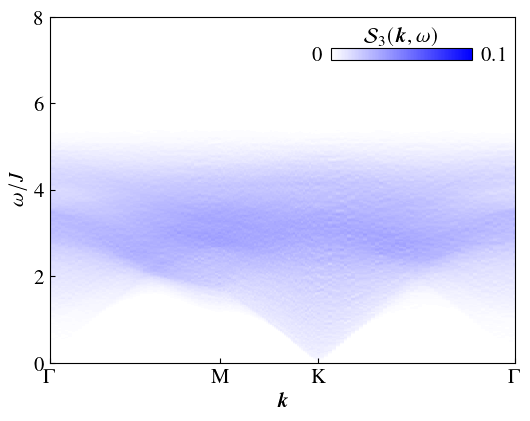

In [16]:
x = kc.len_list
axis_X, axis_Y = np.meshgrid(x, ω_list)
Intensity = (np.array(Sxx) + np.array(Syy) + np.array(Szz)).transpose()

fig, ax = plt.subplots()

cmap = colors.LinearSegmentedColormap.from_list("white_to_blue", [(1, 1, 1), (0, 0, 1)], N = 100)
imag = ax.pcolormesh(axis_X, axis_Y, Intensity, cmap = cmap, shading = "auto", vmin = 0, vmax = 0.1)
# uncomment the following line if you like to overplot the 1-magnon dispersion
# ax.plot(x, np.array(omega_k), 'r--')

ax.set_xlim(x[0], x[-1])
ax.set_ylim(0.0, 8.0)
ax.set_xticks([x[0], xtic_M, xtic_K, x[-1]], [r"$\Gamma$", "M", "K", r"$\Gamma$"])
ax.set_yticks([0, 2, 4, 6, 8])
ax.set_xlabel(r"$\bm{k}$")
ax.set_ylabel(r"$\omega/J$")
ax.tick_params(direction = 'in', color = 'black')

ax.text(6.7, 7.4, r'$\mathcal{S}_3(\bm{k},\omega)$', fontsize = 15)
ax.text(5.6, 7.0, r'$0$', fontsize = 15)
ax.text(9.2, 7.0, r'$0.1$', fontsize = 15)

cax  = ax.inset_axes((6.0, 7.0, 3.0, 0.28), transform = ax.transData)
cbar = fig.colorbar(imag, cax = cax, orientation = "horizontal")
cbar.set_ticks([0, 0.1])
cbar.set_ticklabels(['', ''])
cbar.ax.tick_params(length = 0)

plt.show()